In [1]:
from pyspark.sql import functions as F

In [2]:
from pyspark.sql import SparkSession

properties = {
    "user": "root",
    "password": "root",
    "driver": "com.mysql.cj.jdbc.Driver"
}

spark = SparkSession.builder \
    .appName("example") \
    .config("spark.dynamicAllocation.enabled", "true") \
    .config("spark.dynamicAllocation.minExecutors", "1") \
    .config("spark.dynamicAllocation.maxExecutors", "50") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.executor.instances", "4") \
    .config("spark.executor.cores", "2") \
    .config("spark.memory.fraction", "0.8") \
    .getOrCreate()

In [3]:
df_annee = spark.read.jdbc(url="jdbc:mysql://mysql:3306/mspr1", table="annee", properties=properties).dropna()
df_criminalite = spark.read.jdbc(url="jdbc:mysql://mysql:3306/mspr1", table="criminalite", properties=properties).dropna()
df_commune = spark.read.jdbc(url="jdbc:mysql://mysql:3306/mspr1", table="commune", properties=properties).dropna()
df_demographie = spark.read.jdbc(url="jdbc:mysql://mysql:3306/mspr1", table="demographie", properties=properties).dropna()
df_emploi = spark.read.jdbc(url="jdbc:mysql://mysql:3306/mspr1", table="emploi", properties=properties).dropna()
df_resultats_elections = spark.read.jdbc(url="jdbc:mysql://mysql:3306/mspr1", table="resultats_elections_nuance", properties=properties).dropna()
df_type_election = spark.read.jdbc(url="jdbc:mysql://mysql:3306/mspr1", table="type_election", properties=properties).dropna()

In [4]:
df = df_resultats_elections.join(df_criminalite, on=["id_criminalite"], how="outer")
df = df.join(df_annee, on=["id_annee"], how="outer")
df = df.join(df_commune, on=["id_commune"], how="outer")
df = df.join(df_demographie, on=["id_demographie"], how="outer")
df = df.join(df_emploi, on=["id_emploi"], how="outer")
df = df.join(df_type_election, on=["id_type_election"], how="outer").cache()
# .join(df_elections, on=["codecommune", "annee"], how="outer").join(df_communes, on=["codecommune"], how="outer").cache()

In [5]:
df_annee.unpersist()
df_criminalite.unpersist()
df_commune.unpersist()
df_demographie.unpersist()
df_resultats_elections.unpersist()
df_type_election.unpersist()

DataFrame[id_type_election: int, type_election: string, tour: string]

In [6]:
df = df.filter((~(df["tour"] == "t2") & (df["reg"] == 93)))

In [7]:
# df_no_crime = df.drop(F.col("crimes_delits")).dropna().cache()

In [8]:
df_toutes_infos = df.dropna().cache()

In [9]:
df_toutes_infos.count() # 4730 = résultats pour 5 tours d'élections, avec la criminalité qui limite l'année à 2016

4730

In [10]:
# df_filtered_year = df_toutes_infos.filter(F.col("annee") > 1990).cache()

In [ ]:
df_filtered_year.sample(0.01).count()

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

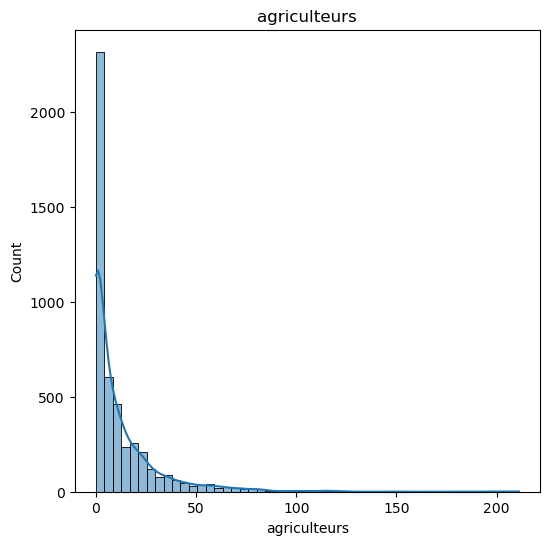

In [95]:
plt.figure(figsize=(6, 6))

plt.subplot(1,1,1)
sns.histplot(df_pandas['agriculteurs'], kde=True, bins = 50)
plt.title("agriculteurs")

plt.show()

In [12]:
# Assuming you have a Pandas DataFrame to convert the Spark DataFrame into Pandas for plotting
df_pandas = df_toutes_infos.toPandas()

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE


In [14]:
scaler = StandardScaler()
scalerX = StandardScaler()
scalerY = StandardScaler()

In [16]:
features_test = ["population", "id_type_election", "crimes_delits", "id_commune", "annee", "agriculteurs", "independants", "cadres", 
                 "intermediaires", "employes", "ouvriers", "chomeurs"]


targets_test = ["nb_inscrits", "nb_voix", "autre_nb_voix", "egauche_nb_voix", "gauche_nb_voix", "cgauche_nb_voix",
                "centre_nb_voix", "cdroit_nb_voix", "droite_nb_voix", "edroite_nb_voix"]

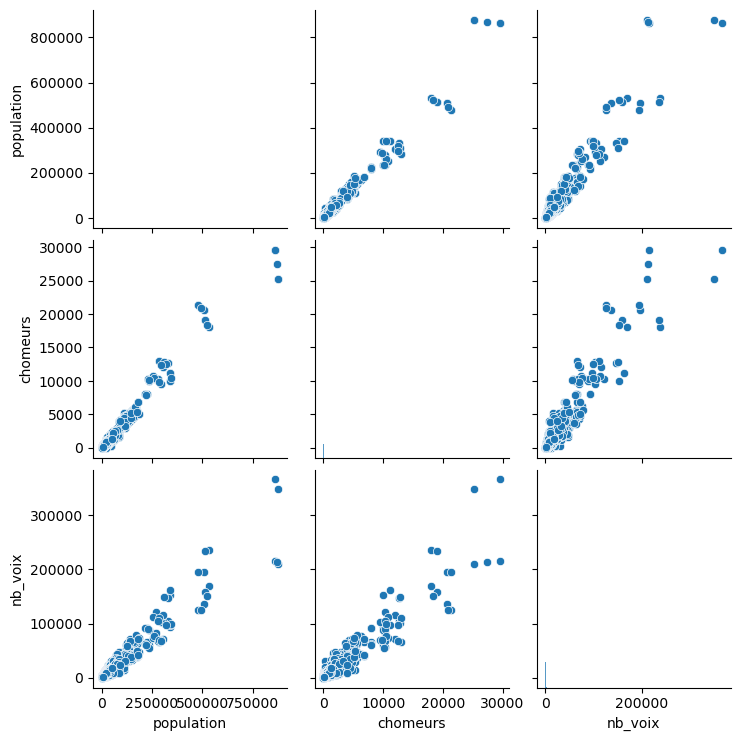

In [25]:
sns.pairplot(df_pandas[['population', 'chomeurs', 'nb_voix']])
plt.show()

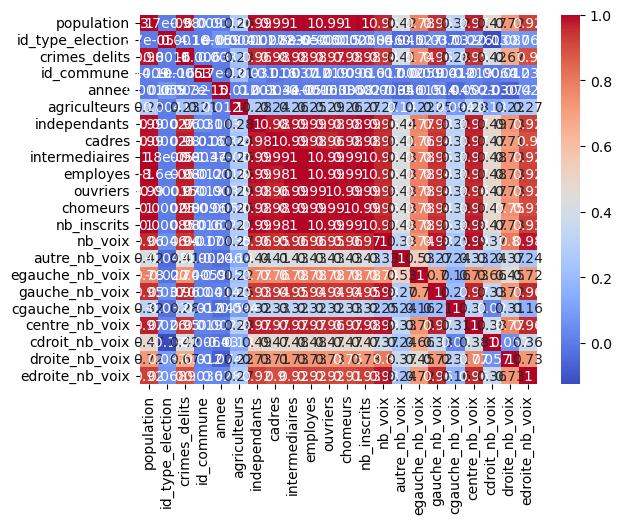

In [143]:
corr_matrix = df_pandas[["population", "id_type_election", "crimes_delits", "id_commune", "annee", "agriculteurs", "independants", "cadres", 
                 "intermediaires", "employes", "ouvriers", "chomeurs", "nb_inscrits", "nb_voix", "autre_nb_voix", "egauche_nb_voix", "gauche_nb_voix", "cgauche_nb_voix",
                "centre_nb_voix", "cdroit_nb_voix", "droite_nb_voix", "edroite_nb_voix"]].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

In [20]:
features_test = ["population", "id_type_election", "crimes_delits", "id_commune", "annee", "agriculteurs", "independants", "cadres", 
                 "intermediaires", "employes", "ouvriers", "chomeurs"]
target = "nb_inscrits"

X = df_pandas[features_test]
Y = df_pandas[target]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)
mse = mean_squared_error(Y_test, Y_pred)
print(f'MSE for {target}: {mse}')
print(f'RMSE for {target}: {np.sqrt(mse)}')

print(f'R2 Score for {target}: {r2_score(Y_test, Y_pred)}')

In [53]:
scaler = StandardScaler()

In [58]:
features_autre = ["population", "crimes_delits", "agriculteurs", "independants", "cadres", 
                 "intermediaires", "employes", "ouvriers", "chomeurs", "population_active_totale",
                 "nb_inscrits", "nb_voix"]
target = "autre_nb_voix"


X = df_pandas[features_autre]
Y = df_pandas[target]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
model = KNeighborsRegressor(n_neighbors=500)
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)
mse = mean_squared_error(Y_test, Y_pred)
print(f'MSE for {target}: {mse}')
print(f'RMSE for {target}: {np.sqrt(mse)}')

print(f'R2 Score for {target}: {r2_score(Y_test, Y_pred)}')

MSE for autre_nb_voix: 1927.6478826934463
RMSE for autre_nb_voix: 43.9049869911545
R2 Score for autre_nb_voix: 0.09874320453581664


In [65]:
features_egauche = ["population", "crimes_delits", "agriculteurs", "independants", "cadres", 
                 "intermediaires", "employes", "ouvriers", "chomeurs", "population_active_totale",
                    "nb_inscrits", "nb_voix"]
target = "egauche_nb_voix"


X = df_pandas[features_autre]
Y = df_pandas[target]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)
mse = mean_squared_error(Y_test, Y_pred)
print(f'MSE for {target}: {mse}')
print(f'RMSE for {target}: {np.sqrt(mse)}')

print(f'R2 Score for {target}: {r2_score(Y_test, Y_pred)}')

MSE for egauche_nb_voix: 75681.62253466768
RMSE for egauche_nb_voix: 275.10293079985115
R2 Score for egauche_nb_voix: 0.6508685961990552


In [78]:
features_gauche = ["population", "crimes_delits", "agriculteurs", "independants", "cadres", 
                 "intermediaires", "employes", "ouvriers", "chomeurs", "population_active_totale",
                    "nb_inscrits", "nb_voix"]
target = "gauche_nb_voix"


X = df_pandas[features_autre]
Y = df_pandas[target]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)
mse = mean_squared_error(Y_test, Y_pred)
print(f'MSE for {target}: {mse}')
print(f'RMSE for {target}: {np.sqrt(mse)}')

print(f'R2 Score for {target}: {r2_score(Y_test, Y_pred)}')

MSE for gauche_nb_voix: 134970.28936104907
RMSE for gauche_nb_voix: 367.3830281341928
R2 Score for gauche_nb_voix: 0.9825075655047827


In [ ]:
features_gauche = ["population", "crimes_delits", "agriculteurs", "independants", "cadres", 
                 "intermediaires", "employes", "ouvriers", "chomeurs", "population_active_totale"]
target = "autre_nb_voix"


X = df_pandas[features_autre]
Y = df_pandas[target]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)
mse = mean_squared_error(Y_test, Y_pred)
print(f'MSE for {target}: {mse}')
print(f'RMSE for {target}: {np.sqrt(mse)}')

print(f'R2 Score for {target}: {r2_score(Y_test, Y_pred)}')

In [37]:
# Convert predictions to a DataFrame
Y_pred_df = pd.DataFrame(Y_pred, columns=[f'pred_{target}'])

# Select a few rows to visualize (for example, the first 10 rows)
comparison_df = pd.DataFrame({
    'True_' + target: Y_test.values[:10]
})

# Add predicted values to the comparison DataFrame
comparison_df['Pred_' + target] = Y_pred_df

# Display the comparison for the first few rows
comparison_df

,True_autre_nb_voix,Pred_autre_nb_voix
0,0,2.843731
1,0,75.525383
2,3,-1.270088
3,12,1.531177
4,0,62.932973
5,12,29.058821
6,0,-1.369891
7,0,50.561754
8,0,-7.308157
9,0,9.791721


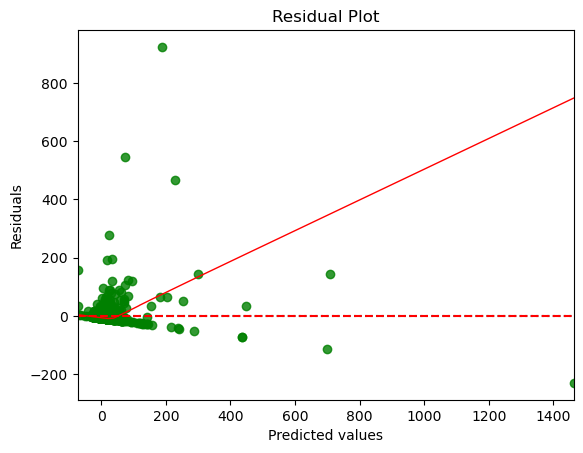

In [144]:
sns.residplot(x=Y_pred, y=Y_test - Y_pred, lowess=True, color="g", line_kws={'color': 'red', 'lw': 1})
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(0, color='red', linestyle='--')
plt.show()

In [ ]:
1834542

In [105]:
rfe = RFE(estimator=model, n_features_to_select=7)
rfe.fit(X_train, Y_train)

selected_features = X_train.columns[rfe.support_]
print("Selected features:", selected_features)

Selected features: Index(['id_type_election', 'annee', 'agriculteurs', 'independants',
       'intermediaires', 'ouvriers', 'chomeurs'],
      dtype='object')


In [108]:
X_train_rfe = X_train[selected_features]
X_test_rfe = X_test[selected_features]

# Fit the model
model.fit(X_train_rfe, Y_train)

# Evaluate the model
print("Training R^2 score:", model.score(X_train_rfe, Y_train))
print("Testing R^2 score:", model.score(X_test_rfe, Y_test))

Training R^2 score: 0.9965070936104641
Testing R^2 score: 0.9954977970157103


In [ ]:
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)

In [79]:
features_test = ["population", "id_type_election", "crimes_delits", "id_commune", "annee", "agriculteurs", "independants", "cadres", 
                 "intermediaires", "employes", "ouvriers", "chomeurs"]
targets_test = ["nb_inscrits", "nb_voix", "autre_nb_voix", "egauche_nb_voix", "gauche_nb_voix", "cgauche_nb_voix",
                "centre_nb_voix", "cdroit_nb_voix", "droite_nb_voix", "edroite_nb_voix"]

X = df_pandas[features_test]
Y = df_pandas[targets_test]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)

In [80]:
for idx, target in enumerate(targets_test):
    mse = mean_squared_error(Y_test[target], Y_pred[:, idx])
    print(f'MSE for {target}: {mse}')
    print(f'RMSE for {target}: {np.sqrt(mse)}')

for idx, target in enumerate(targets_test):
    print(f'R2 Score for {target}: {r2_score(Y_test[target], Y_pred[:, idx])}')

MSE for nb_inscrits: 1590607.4021644602
RMSE for nb_inscrits: 1261.1928489190145
MSE for nb_voix: 10914257.790350696
RMSE for nb_voix: 3303.673378279199
MSE for autre_nb_voix: 5658.864324424114
RMSE for autre_nb_voix: 75.22542339145798
MSE for egauche_nb_voix: 66495.63562745055
RMSE for egauche_nb_voix: 257.86747687029197
MSE for gauche_nb_voix: 701313.3383419224
RMSE for gauche_nb_voix: 837.4445285163205
MSE for cgauche_nb_voix: 1107.4587646143282
RMSE for cgauche_nb_voix: 33.278503040466354
MSE for centre_nb_voix: 651893.0728484349
RMSE for centre_nb_voix: 807.3989551940447
MSE for cdroit_nb_voix: 280357.76144417113
RMSE for cdroit_nb_voix: 529.4882070869672
MSE for droite_nb_voix: 2173464.0506790136
RMSE for droite_nb_voix: 1474.2672928200684
MSE for edroite_nb_voix: 1492922.9098399975
RMSE for edroite_nb_voix: 1221.852245502703
R2 Score for nb_inscrits: 0.9960964459654914
R2 Score for nb_voix: 0.8847759353427459
R2 Score for autre_nb_voix: -1.6457580623442807
R2 Score for egauche_n

In [79]:
for idx, target in enumerate(targets_test):
    mse = mean_squared_error(Y_test[target], Y_pred[:, idx])
    print(f'MSE for {target}: {mse}')
    print(f'RMSE for {target}: {np.sqrt(mse)}')

for idx, target in enumerate(targets_test):
    print(f'R2 Score for {target}: {r2_score(Y_test[target], Y_pred[:, idx])}')

MSE for nb_inscrits: 345372.8759742971
RMSE for nb_inscrits: 587.6843336131202
MSE for nb_voix: 856935.4478141031
RMSE for nb_voix: 925.7080791556824
MSE for autre_nb_voix: 33142.31336132543
RMSE for autre_nb_voix: 182.05030448017777
MSE for egauche_nb_voix: 17764.633304890038
RMSE for egauche_nb_voix: 133.28403244533848
MSE for gauche_nb_voix: 138152.65440241297
RMSE for gauche_nb_voix: 371.6889215492076
MSE for cgauche_nb_voix: 3558.802745807883
RMSE for cgauche_nb_voix: 59.655701704094334
MSE for centre_nb_voix: 143391.55316608594
RMSE for centre_nb_voix: 378.6707714705295
MSE for cdroit_nb_voix: 16673.05601597078
RMSE for cdroit_nb_voix: 129.12418834583542
MSE for droite_nb_voix: 295198.4457062448
RMSE for droite_nb_voix: 543.3216779277676
MSE for edroite_nb_voix: 90971.34015926937
RMSE for edroite_nb_voix: 301.6145556157218
R2 Score for nb_inscrits: 0.9875598032959264
R2 Score for nb_voix: 0.9078485350591601
R2 Score for autre_nb_voix: 0.14055746847903905
R2 Score for egauche_nb_v

In [80]:
# Convert predictions to a DataFrame
Y_pred_df = pd.DataFrame(Y_pred, columns=[f'pred_{col}' for col in targets_test])

# Select a few rows to visualize (for example, the first 10 rows)
comparison_df = pd.DataFrame({
    'True_' + target: Y_test[target].values[:10] for target in ["nb_inscrits", "nb_voix"]
})

# Add predicted values to the comparison DataFrame
for idx, target in enumerate(["nb_inscrits", "nb_voix"]):
    comparison_df['Pred_' + target] = Y_pred_df.iloc[:10, idx]

# Display the comparison for the first few rows
comparison_df

,True_nb_inscrits,True_nb_voix,Pred_nb_inscrits,Pred_nb_voix
0,75,29,115.380046,72.838439
1,484,222,510.249612,304.878330
2,571,473,514.193045,283.956383
3,2521,1140,1821.982012,792.241134
4,1340,687,1236.224814,784.187716
5,400,259,521.165251,340.561648
6,1792,762,1573.978992,945.381484
7,275,144,419.015479,270.676377
8,86,37,140.957407,89.061093
9,72,31,78.099050,32.287614


In [ ]:
X_train_scaled = scalerX.fit_transform(X_train)
X_test_scaled = scalerX.fit_transform(X_test)

Y_train = Y_train.values.ravel()  # Convert to 1D array

model = RandomForestRegressor()
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)


In [18]:
X_train_scaled = scalerX.fit_transform(X_train)
Y_train_scaled = scalerY.fit_transform(Y_train)
X_test_scaled = scalerX.fit_transform(X_test)

base_model = LinearRegression()
multi_target_regressor = MultiOutputRegressor(base_model)
multi_target_regressor.fit(X_train_scaled, Y_train_scaled)

Y_pred_scaled = multi_target_regressor.predict(X_test_scaled)
Y_pred_original = scalerY.inverse_transform(Y_pred_scaled)


for idx, target in enumerate(targets):
    print(f'MSE for {target}: {mean_squared_error(Y_test[target], Y_pred_original[:, idx])}')

MSE for nb_inscrits: 386695.6535679141
MSE for nb_voix: 820995.92729004
MSE for autre_nb_voix: 2525.7240212024585
MSE for egauche_nb_voix: 6358.511837649619
MSE for gauche_nb_voix: 99460.05603051229
MSE for cgauche_nb_voix: 585.4611972529354
MSE for centre_nb_voix: 67624.70086454626
MSE for cdroit_nb_voix: 9229.406920113855
MSE for droite_nb_voix: 98026.31792605671
MSE for edroite_nb_voix: 132399.91450881946


In [20]:
# Convert predictions to a DataFrame
Y_pred_df = pd.DataFrame(Y_pred_original, columns=[f'pred_{col}' for col in targets])

# Select a few rows to visualize (for example, the first 10 rows)
comparison_df = pd.DataFrame({
    'True_' + target: Y_test[target].values[:10] for target in ["droite_nb_voix", "edroite_nb_voix"]
})

# Add predicted values to the comparison DataFrame
for idx, target in enumerate(["droite_nb_voix", "edroite_nb_voix"]):
    comparison_df['Pred_' + target] = Y_pred_df.iloc[:10, idx]

# Display the comparison for the first few rows
comparison_df

,True_droite_nb_voix,True_edroite_nb_voix,Pred_droite_nb_voix,Pred_edroite_nb_voix
0,24,39,425.141908,282.864145
1,58,252,845.019241,608.651291
2,0,239,1337.397774,809.041050
3,5,27,107.114801,107.037162
4,1,3,89.537643,96.782938
5,203,261,912.512210,605.151781
6,0,127,621.267007,373.286330
7,70,61,373.465138,253.035074
8,444,261,4053.125887,2523.117715
9,16,10,94.514920,85.386747


In [41]:
from sklearn.ensemble import RandomForestRegressor

In [15]:
features = ["population", "crimes_delits", "agriculteurs", "independants", "cadres", "intermediaires", "employes", "ouvriers", "population_active_totale", "chomeurs"]
targets = ["nb_inscrits", "nb_voix", "autre_nb_voix", "egauche_nb_voix", "gauche_nb_voix", "cgauche_nb_voix",
                "centre_nb_voix", "cdroit_nb_voix", "droite_nb_voix", "edroite_nb_voix"]

In [67]:
features = ["population", "crimes_delits", "agriculteurs", "independants", "cadres", "intermediaires", "employes", "ouvriers", "population_active_totale", "chomeurs"]
targets = ["autre_pourcentage_voix_inscrits", "egauche_pourcentage_voix_inscrits",
           "gauche_pourcentage_voix_inscrits", "cgauche_pourcentage_voix_inscrits",
            "centre_pourcentage_voix_inscrits", "cdroit_pourcentage_voix_inscrits",
           "droite_pourcentage_voix_inscrits", "edroite_pourcentage_voix_inscrits"]

In [68]:
scalerX = StandardScaler()
scalerY = StandardScaler()

In [70]:
X = df_pandas[features]
Y = df_pandas[targets]

In [71]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [72]:
X_train_scaled = scalerX.fit_transform(X_train)
Y_train_scaled = scalerY.fit_transform(Y_train)
X_test_scaled = scalerX.fit_transform(X_test)

base_model = RandomForestRegressor()
multi_target_regressor = MultiOutputRegressor(base_model)
multi_target_regressor.fit(X_train_scaled, Y_train_scaled)

Y_pred_scaled = multi_target_regressor.predict(X_test_scaled)
Y_pred_original = scalerY.inverse_transform(Y_pred_scaled)

mse_targets = []
for idx, target in enumerate(targets):
    print(f'MSE for {target}: {mean_squared_error(Y_test[target], Y_pred_original[:, idx])}')

for idx, target in enumerate(targets):
    print(f'R2 Score for {target}: {r2_score(Y_test[target], Y_pred_original[:, idx])}')

MSE for autre_pourcentage_voix_inscrits: 1.719487691877282
MSE for egauche_pourcentage_voix_inscrits: 4.169968923459926
MSE for gauche_pourcentage_voix_inscrits: 44.258227038272715
MSE for cgauche_pourcentage_voix_inscrits: 0.3485637028579244
MSE for centre_pourcentage_voix_inscrits: 32.01916496670678
MSE for cdroit_pourcentage_voix_inscrits: 8.51880090408696
MSE for droite_pourcentage_voix_inscrits: 63.39100636372976
MSE for edroite_pourcentage_voix_inscrits: 91.89736356660342
R2 Score for autre_pourcentage_voix_inscrits: -0.12908270023359836
R2 Score for egauche_pourcentage_voix_inscrits: -0.12615851814436896
R2 Score for gauche_pourcentage_voix_inscrits: 0.1949376594257487
R2 Score for cgauche_pourcentage_voix_inscrits: -0.19753146994950987
R2 Score for centre_pourcentage_voix_inscrits: 0.09478860001018796
R2 Score for cdroit_pourcentage_voix_inscrits: -0.154645875893054
R2 Score for droite_pourcentage_voix_inscrits: -0.05267171707227325
R2 Score for edroite_pourcentage_voix_inscrit

In [77]:
# Convert predictions to a DataFrame
Y_pred_df = pd.DataFrame(Y_pred_original, columns=[f'pred_{col}' for col in targets])

# Select a few rows to visualize (for example, the first 10 rows)
comparison_df = pd.DataFrame({
    'True_' + target: Y_test[target].values[:20] for target in ["droite_pourcentage_voix_inscrits", "edroite_pourcentage_voix_inscrits"]
})

# Add predicted values to the comparison DataFrame
for idx, target in enumerate(["droite_pourcentage_voix_inscrits", "edroite_pourcentage_voix_inscrits"]):
    comparison_df['Pred_' + target] = Y_pred_df.iloc[:20, idx]

# Display the comparison for the first few rows
comparison_df

,True_droite_pourcentage_voix_inscrits,True_edroite_pourcentage_voix_inscrits,Pred_droite_pourcentage_voix_inscrits,Pred_edroite_pourcentage_voix_inscrits
0,0.000000,19.53820,0.493338,1.822249
1,20.695000,27.10420,0.285285,2.041350
2,3.773580,10.84910,0.286498,2.907902
3,0.396825,17.46030,0.329195,3.993451
4,17.778500,33.22460,0.475005,1.081946
5,8.934500,10.98700,0.447241,2.457747
6,14.150900,26.88680,0.286498,2.907902
7,5.843200,32.24850,0.295558,1.956249
8,21.194400,21.66280,0.625289,1.995098
9,4.724410,8.66142,0.346509,3.284350


In [5]:
# spark.stop()